# 8_Market_Research_Analysis

<a id='back'><a/>
# Table of Contents
    
- [1. Market Research Analysis Overview](#1)
- [2. General Information Overview](#2)
- [3. Data Preprocessing](#3)
    - [3.1 Cleaning up Establishment Names](#3.1)
    - [3.2 Changing Data Types](#3.2)
    - [3.3 Missing Values](#3.3)
- [4. Exploratory Data Analysis](#4)
    - [4.1 Types of Establishments](#4.1)
    - [4.2 Chain vs. Non-Chain](#4.2)
    - [4.3 Average Number of Seats](#4.3)
    - [4.4 Top 10 Streets By Number of Establishments](#4.4)
    - [4.5 Streets with Only One Restaurant](#4.5)
    - [4.6 Distribution of the Number of Seats on Streets with Many Establishments](#4.6)
- [5. General Conclusion](#5)

<a id='1'><a/>
# 1. Market Research Analysis Overview
[Return to Table of Contents](#back)

An entrepreneur has decided to open a small robot-run cafe in Los Angeles. The project is promising but expensive and so will require investor funding. Prospective investors are interested in the current market conditions, but have concerns surrounding long-term success, once the novelty of robot waiters wears off.
For this entrepreneur, we have been asked to perform some market research utilizing open-source data on restaurants in LA to provide insights into the long-term demand trends for a robot cafe.

In this document you will find the analysis performed and in the link below a PDF presentation of our findings to share with prospective investors. Most analysis of charts appear in the PDF presentation versus this document.

Presentation: <https://drive.google.com/file/d/1QrdKHhDdhaWcrJ70m4jDiGSc-lrhedk2/view?usp=sharing>

<a id='2'><a/>
# 2. General Information Overview
[Return to Table of Contents](#back)

In [1]:
# import libraries

import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pip

In [2]:
# read all input data

try: # local path
    df = pd.read_csv('rest_data_us.csv')
except: # server path
    df = pd.read_csv('/datasets/rest_data_us.csv')

In [3]:
df.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 2.4 MB


In [5]:
for c in df.select_dtypes(include ='object').columns: 
    print()
    print(c)
    print(df[c].value_counts())


object_name
THE COFFEE BEAN & TEA LEAF    47
SUBWAY                        31
DOMINO'S PIZZA                15
WABA GRILL                    14
KENTUCKY FRIED CHICKEN        14
                              ..
HAMASAKU                       1
CRYSTAL CAFE                   1
ADOBO GRILL                    1
PEPES G. TACOS                 1
ROSEN MUSIC STUDIO             1
Name: object_name, Length: 8672, dtype: int64

address
3607 TROUSDALE PKWY            11
135 N GRAND AVE                10
400 WORLD WAY                   9
600 WORLD WAY                   9
5151 STATE UNIVERSITY DR        9
                               ..
2719 W 6TH ST                   1
12400 WILSHIRE BLVD STE 150     1
1948 COLORADO BLVD              1
404 S FIGUEROA ST STE #417      1
4306 N FIGUEROA                 1
Name: address, Length: 8517, dtype: int64

chain
False    5972
True     3676
Name: chain, dtype: int64

object_type
Restaurant    7255
Fast Food     1066
Cafe           435
Pizza          320
Bar

In [6]:
df.duplicated().sum()

0

The file contains 9,651 lines with no duplicates and only 3 missing values (which will be dropped). Only one series, 'object_type' needs for its data type to be changed (it should be 'category). We will likely have to explore the 'object_name' series as it seems that the identification numbers for a given establishment's chain is included as well as the names for some restaurants differing slightly. When grouping, this will throw off our analysis.

<a id='3'><a/>
# 3. Data Preprocessing
[Return to Table of Contents](#back)

<a id='3.1'><a/>
## 3.1 Cleaning up Establishment Names
[Return to Table of Contents](#back)

In [7]:
# check if chain names also include individual chain identifiers

df[df['object_name'].str.contains('#')].sample()

,id,object_name,address,chain,object_type,number
9175,20961,STARBUCKS COFFEE #25043,3201 S HOOVER ST,True,Cafe,22


In [8]:
# dropping text after '#'

df['establishment_new'] = df['object_name'].str.split('#').str[0]

In [9]:
# renaming columns so that they are clearer

df.columns = ['id', 'establishment_old','address','chain','establishment_type','number_of_seats','establishment_new']

In [10]:
# correcting establishment names that appear mutliple times with slight differences in spelling, etc.

def rename_establishment(x):
    if 'SUBWAY' in x:
        new_est = 'SUBWAY'
    elif 'STARBUCKS' in x:
        new_est = 'STARBUCKS'
    elif 'MCDONALD' in x:
        new_est = 'MCDONALDS'
    elif "DOMINO'S PIZZA" in x:
        new_est = "DOMINO'S PIZZA"
    elif 'JAMBA' in x:
        new_est = 'JAMBA JUICE'
    elif 'EL POLLO LOCO' in x:
        new_est = 'EL POLLO LOCO'
    elif 'TACO BELL' in x:
        new_est = 'TACO BELL'
    elif 'PANDA EXPRESS' in x:
        new_est = 'PANDA EXPRESS'
    elif "CARL'S JR" in x or "CARLS JR" in x:
        new_est = "CARL'S JR"
    elif 'CHIPOTLE' in x:
        new_est = 'CHIPOTLE'
    elif 'CHINATOWN EXPRESS' in x:
        new_est = 'CHINATOWN EXPRESS'
    elif 'KENTUCKY FRIED CHICKEN' in x:
        new_est = 'KFC'
    elif 'LITTLE CAESARS' in x:
        new_est = 'LITTLE CAESARS'
    elif 'COFFEE BEAN & TEA LEAF' in x or 'COFFEE BEAN AND TEA LEAF' in x:
        new_est = 'THE COFFEE BEAN & TEA LEAF'
        # the else was a catch-all that I kept running until I had gotten all the text into the above categories
    else:
        new_est = x
    return new_est

#df['establishment_new'].apply(rename_establishment).value_counts().head(50)
# the above was a test to look for repeat names amongst the bigger chains
df['establishment_new'] = df['establishment_new'].apply(rename_establishment)

<a id='3.2'><a/>
## 3.2 Changing Data Types
[Return to Table of Contents](#back)

In [11]:
# converting establishment type to the 'category' data type

df['establishment_type'] = df['establishment_type'].astype('category')

<a id='3.3'><a/>
## 3.3 Missing Values
[Return to Table of Contents](#back)

In [12]:
# dropping the 3 missing values

df.dropna(inplace=True)

The most significant data preprocessing that we performed was related to correcting establishment names that appear mutliple times with slight differences in spelling, etc.

<a id='4'><a/>
# 4. Exploratory Data Analysis
[Return to Table of Contents](#back)

<a id='4.1'><a/>
## 4.1 Types of Establishments
[Return to Table of Contents](#back)

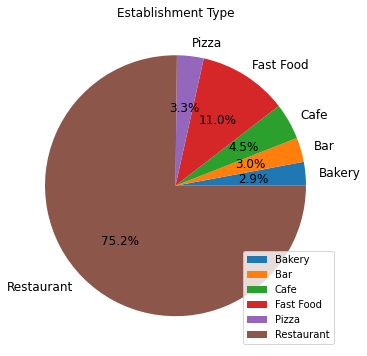

In [13]:
# proportions of the various types of establishments

df.groupby(['establishment_type']).count().plot.pie(y='id', autopct='%1.1f%%', figsize=(16, 6),fontsize=12)
plt.title('Establishment Type')
# check this later
plt.yticks(color='w')
plt.legend(loc='lower right')
plt.xlabel('')
plt.ylabel('')
plt.show() 

Restaurants make up the lions share of establishments (75.2%). Cafes make up only 4.5% of all establishments

<a id='4.2'><a/>
## 4.2 Chain vs. Non-Chain
[Return to Table of Contents](#back)

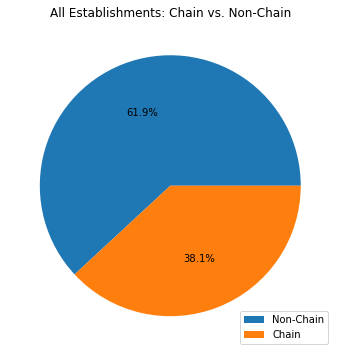

In [14]:
# proportions of chain and nonchain establishments

plt.figure(figsize=(15, 6))

ax = df['chain'].value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%',labels=None)

plt.title('All Establishments: Chain vs. Non-Chain')
plt.legend(['Non-Chain','Chain'], loc='lower right')
plt.xlabel('')
plt.ylabel('')

plt.show()

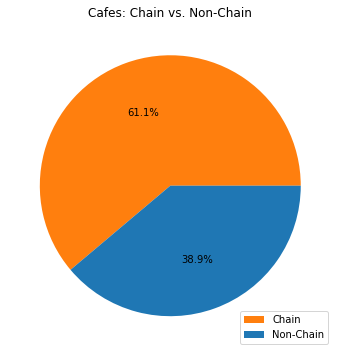

In [15]:
# proportions of chain and nonchain cafes

plt.figure(figsize=(15, 6))

df_cafe_only = df[df['establishment_type'] == 'Cafe'].copy()

ax = df_cafe_only['chain'].value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%',labels=None, colors=['tab:orange','tab:blue'])

plt.title('Cafes: Chain vs. Non-Chain')
plt.legend(['Chain','Non-Chain'], loc='lower right')
plt.xlabel('')
plt.ylabel('')

plt.show()

Cafes are largely characterized as not belonging to a Chain, much more so than other establishments

posx and posy should be finite values
posx and posy should be finite values


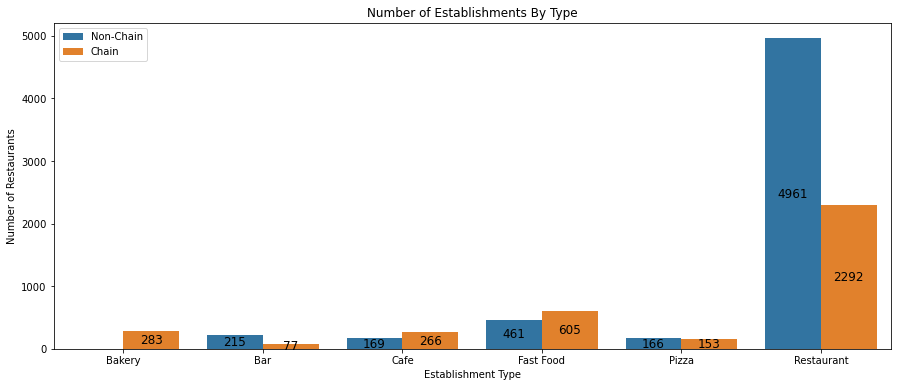

In [16]:
plt.figure(figsize=(15, 6))
ax = sns.countplot(x="establishment_type", data=df, hue='chain', palette=['tab:blue','tab:orange'])
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=12,)
  
plt.title('Number of Establishments By Type')
plt.xlabel('Establishment Type')
plt.ylabel('Number of Restaurants')
plt.legend(['Non-Chain','Chain'], loc='upper left')

plt.show()

Bakeries, Cafes and Fast Food are more likely to be Chains. Of the 435 cafes, only 169 are not part of a chain.

In [17]:
chain_count = df[df['chain'] == True].groupby('establishment_new').count().sort_values(by='id', ascending=False).drop(['establishment_old','address','chain','establishment_type','number_of_seats'], axis=1).reset_index()
chain_seats = df[df['chain'] == True].groupby('establishment_new')['number_of_seats'].mean().sort_values(ascending=False).reset_index()
chain_count_seats=chain_count.merge(chain_seats, on='establishment_new', how='inner')

In [18]:
chain_count_seats.shape

(2079, 3)

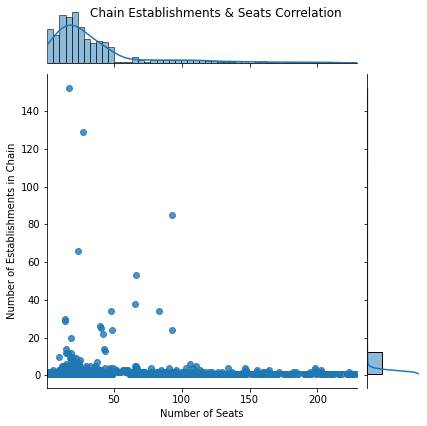

In [19]:
sns.jointplot(x="number_of_seats", y="id", data=chain_count_seats, kind="reg")

plt.suptitle('Chain Establishments & Seats Correlation')
plt.xlabel('Number of Seats')
plt.ylabel('Number of Establishments in Chain')
plt.show()

In [20]:
# test to make sure there are no abnormally low numbers

chain_count_seats[chain_count_seats['number_of_seats'] <= 5].count()

establishment_new    165
id                   165
number_of_seats      165
dtype: int64

In [21]:
chain_count_seats.corr()

,id,number_of_seats
id,1.000000,-0.002734
number_of_seats,-0.002734,1.000000


There is barely a correlation between number of seats and the number of establishments. Chains are more likely to have fewer seats (i.e. under 50) but that is independent from how many establishments are in the chain to which they belong.

<a id='4.3'><a/>
## 4.3 Average Number of Seats
[Return to Table of Contents](#back)

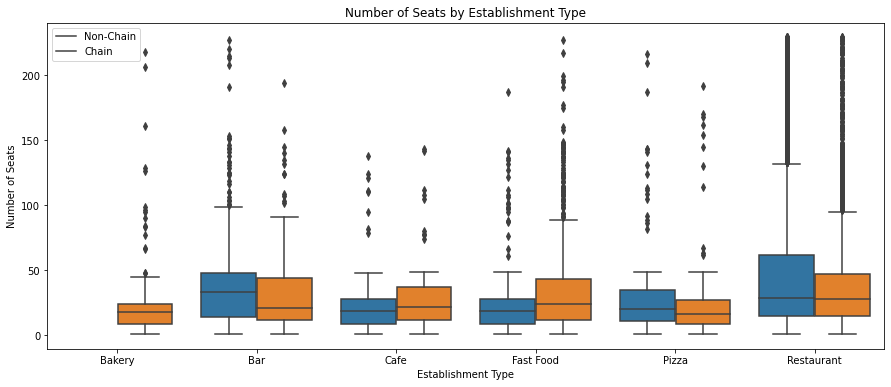

In [22]:
# average number of seats for each type of restaurant

plt.figure(figsize=(15, 6))

sns.boxplot(x="establishment_type", y="number_of_seats", data=df, hue='chain', palette=['tab:blue','tab:orange'])

plt.title('Number of Seats by Establishment Type')
plt.xlabel('Establishment Type')
plt.ylabel('Number of Seats')
plt.legend(['Non-Chain','Chain'], loc='upper left')
legends = ax.get_legend()
legends.legendHandles[0].set_color('blue')
legends.legendHandles[1].set_color('orange')

plt.show()

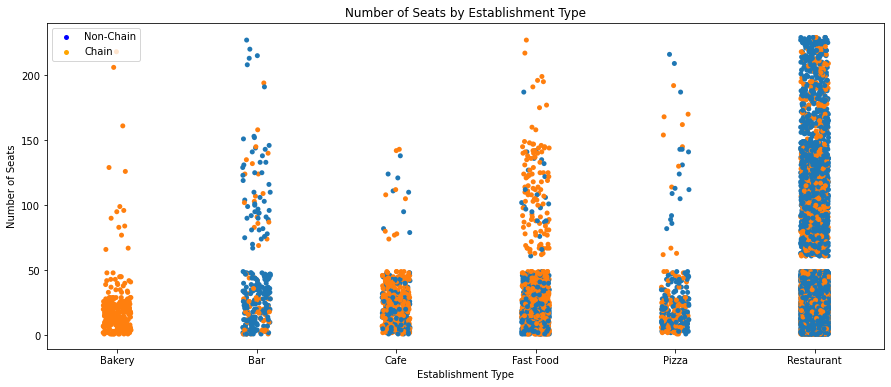

In [23]:
plt.figure(figsize=(15, 6))

ax = sns.stripplot(x="establishment_type", y="number_of_seats", hue="chain", data=df, palette=['tab:blue','tab:orange'])

plt.title('Number of Seats by Establishment Type')
plt.xlabel('Establishment Type')
plt.ylabel('Number of Seats')
plt.legend(['Non-Chain','Chain'], loc='upper left')
legends = ax.get_legend()
legends.legendHandles[0].set_color('blue')
legends.legendHandles[1].set_color('orange')
plt.show()

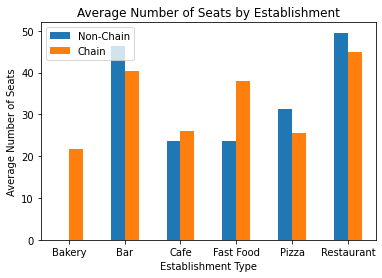

In [24]:
# average number of seats

df.groupby(['establishment_type','chain'])['number_of_seats'].mean().unstack(1).plot(kind='bar')
plt.title('Average Number of Seats by Establishment')
plt.xlabel('Establishment Type')
plt.ylabel('Average Number of Seats')
plt.xticks(rotation=0)
plt.legend(['Non-Chain','Chain'], loc='upper left')
plt.show()

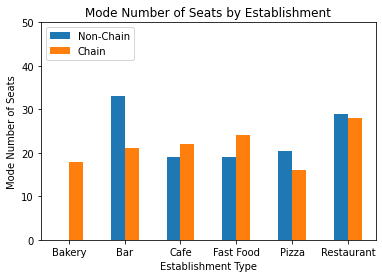

In [25]:
# median number of seats

df.groupby(['establishment_type','chain'])['number_of_seats'].median().unstack(1).plot(kind='bar')

plt.title('Mode Number of Seats by Establishment')
plt.xlabel('Establishment Type')
plt.ylabel('Mode Number of Seats')
plt.xticks(rotation=0)
plt.ylim(0, 50) 
plt.legend(['Non-Chain','Chain'], loc='upper left')
plt.show()

Most Establishments have fewer than 50 seats on average, while the mode if far below that, under 30. Only chain cafes and fast food types have more seats than their non-chain equivalent. Cafes, especially non-chain cafes, fall on the lower end of the below 50-seat spectrum, with an average of 24 seats and a median of 19.

<a id='4.4'><a/>
## 4.4 Top 10 Streets By Number of Establishments
[Return to Table of Contents](#back)

In [26]:
# putting the data on street names from the address column in a separate column

import re as re

def words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

df['street_name']=df['address'].apply(lambda x : words(x)).str.lower()
df_cafe_only['street_name']=df_cafe_only['address'].apply(lambda x : words(x)).str.lower()

In [27]:
# grabbing the top 10 most popular streets

popular_streets = df.groupby(['street_name'])['id'].count().nlargest(10).to_frame().reset_index()

In [29]:
popular_streets_cafes = df_cafe_only.groupby(['street_name'])['id'].count().nlargest(12).to_frame().reset_index()

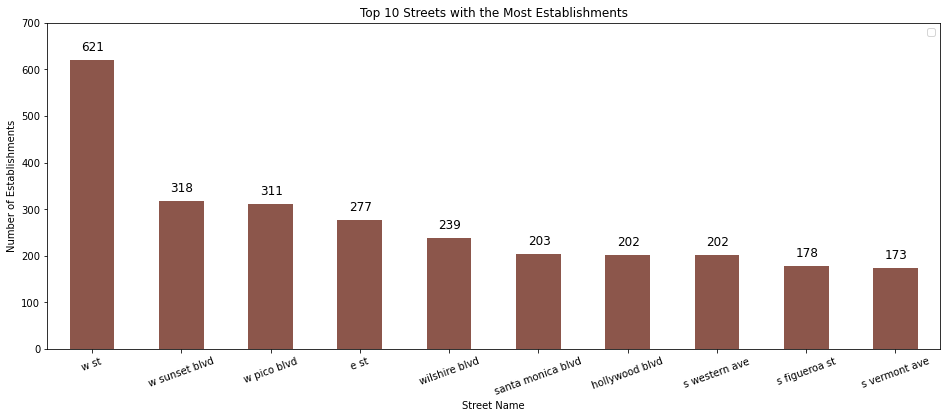

In [30]:
# top ten streets by number of establishments

ax = popular_streets.plot(x='street_name', kind='bar',figsize=(16, 6), color='tab:brown')

ax.set_title("Top 10 Streets with the Most Establishments")
ax.set_ylabel("Number of Establishments")
ax.set_xlabel('Street Name')
ax.set_yticks([0, 100, 200, 300, 400, 500, 600, 700])
plt.xticks(rotation=20)
plt.legend([])

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.13, i.get_height()+20, \
            str(round(i.get_height())), fontsize=12, color='black')

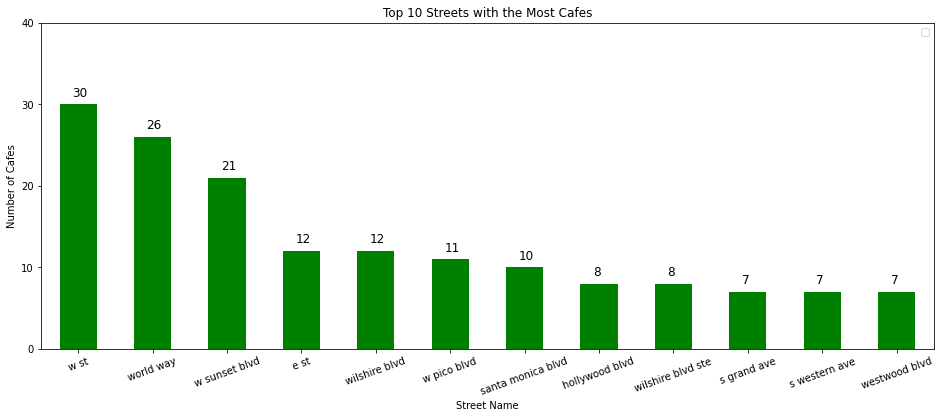

In [31]:
# top ten streets by number of cafes

ax = popular_streets_cafes.plot(x='street_name', kind='bar',figsize=(16, 6), color='green')

ax.set_title("Top 10 Streets with the Most Cafes")
ax.set_ylabel("Number of Cafes")
ax.set_xlabel('Street Name')
ax.set_yticks([0, 10, 20, 30,40])
plt.xticks(rotation=20)
plt.legend([])

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.17, i.get_height()+1, \
            str(round(i.get_height())), fontsize=12, color='black')

The first 8 of the 10 most popular streets for all eating establishments are also the same for cafes. However, the bottom 2 (S Figueroa, Vermont Ave) do not appear in the cafe top 10 list. This suggests that there is an underrepresentation of cafes on these popular streets

<a id='4.5'><a/>
## 4.5 Streets with Only One Restaurant
[Return to Table of Contents](#back)

In [32]:
one_rest_per_street = (df.groupby(['street_name'])['id'].count() ==1).reset_index()
one_cafe_per_street = (df_cafe_only.groupby(['street_name'])['id'].count() ==1).reset_index()

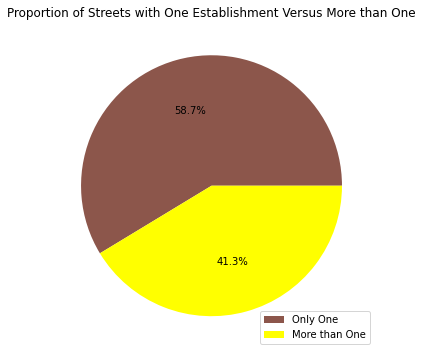

In [33]:
# streets that only have one establishment

plt.figure(figsize=(15, 6))

ax = one_rest_per_street['id'].value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%',labels=None, colors = ['tab:brown', 'yellow'])

plt.title('Proportion of Streets with One Establishment Versus More than One')
plt.legend(['Only One','More than One'], loc='lower right')
plt.xlabel('')
plt.ylabel('')

plt.show()

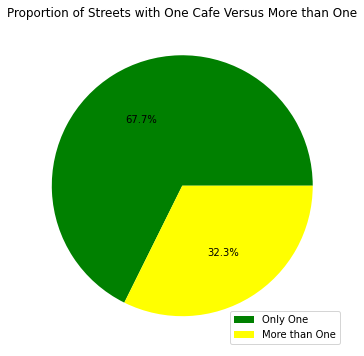

In [34]:
# streets that only have one cafe

plt.figure(figsize=(15, 6))

ax = one_cafe_per_street['id'].value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%',labels=None, colors = ['green', 'yellow'])

plt.title('Proportion of Streets with One Cafe Versus More than One')
plt.legend(['Only One','More than One'], loc='lower right')
plt.xlabel('')
plt.ylabel('')

plt.show()

In [35]:
print("There are {} streets with only one establishment. They represent 58.7% of all establishments.".format(len(one_rest_per_street[one_rest_per_street['id'] == True])))

There are 775 streets with only one establishment. They represent 58.7% of all establishments.


In [36]:
print("There are {} streets with only one cafe. They represent 67.7% of all cafes.".format(len(one_cafe_per_street[one_cafe_per_street['id'] == True])))

There are 134 streets with only one cafe. They represent 67.7% of all cafes.


<a id='4.6'><a/>
## 4.6 Distribution of the Number of Seats on Streets with Many Establishments
[Return to Table of Contents](#back)

In [37]:
test = df.groupby(['street_name'])['id'].count().sort_values(ascending=False).reset_index()

In [38]:
# 90th and 95th percentiles

np.percentile(test['id'], [90, 95])

array([12., 31.])

In [39]:
# streets with a lot of restaurants, defined as over 30

streets_30_plus = test[test['id'] >= 30]['street_name']

In [40]:
many_restaurants = df[df['street_name'].isin(streets_30_plus)]

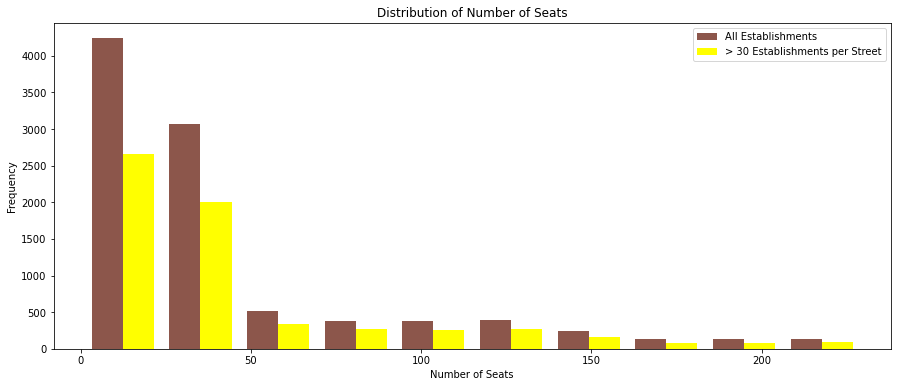

In [41]:
# For streets with a lot of restaurants, a look at the distribution of the number of seats
# I chose not to do a distplot as that function has been depracated

plt.figure(figsize=(15, 6))
plt.hist([df['number_of_seats'], many_restaurants['number_of_seats']], bins=10, label=['All Establishments', '> 30 Establishments per Street'], color=['tab:brown','yellow'])
plt.title('Distribution of Number of Seats')
plt.legend(loc='upper right')
plt.xlabel('Number of Seats')
plt.ylabel('Frequency')
plt.show()

The more establishments on a street, the less seats available. Popular (i.e. crowded) streets likely offer fewer seats as real estate is at a premium in these areas.

<a id='5'><a/>
# 5. General Conclusion
[Return to Table of Contents](#back)

In today’s market, cafes make up only 4.5% of the eating establishment market in LA and over 60% are chains. Nearly 68% of cafes tend to be the only one of their kind on a street versus 59% of all eating establishments.

However, the characteristics intrinsic to cafes suggest that there is an opportunity for a non-chain cafe on more popular streets (i.e. more than 30 establishments) where there is more foot traffic and thus revenue opportunity.

Cafes do not require as many seats as other eating establishments and so cafes are better suited to popular streets that are characterized by offering less space (i.e. fewer seats)


‘Robot Cafe’, a non-chain cafe, located on one of the most popular streets where we have identified that cafes do not have enough presence (S Figueroa, Vermont Ave, Olympic Blvd, Beverly Blvd) would have a high likelihood of success.


Looking ahead, if successful, ‘Robot Cafe’ could become a chain though there would be additional challenges as this is a niche, differentiated product that would be competing against a larger market of cafe chains.